In [1]:
!pip install -q langchain-graph-retriever

In [2]:
!pip install -q graph_rag_example_helpers

In [13]:
!pip install -q langchain_google-genai langchain_huggingface

In [5]:
from graph_rag_example_helpers.datasets.animals import fetch_documents

In [6]:
animals=fetch_documents()

In [7]:
animals

[Document(id='aardvark', metadata={'type': 'mammal', 'number_of_legs': 4, 'keywords': ['burrowing', 'nocturnal', 'ants', 'savanna'], 'habitat': 'savanna', 'tags': [{'a': 5, 'b': 7}, {'a': 8, 'b': 10}]}, page_content='the aardvark is a nocturnal mammal known for its burrowing habits and long snout used to sniff out ants.'),
 Document(id='albatross', metadata={'type': 'bird', 'number_of_legs': 2, 'keywords': ['seabird', 'wingspan', 'ocean'], 'habitat': 'marine', 'tags': [{'a': 5, 'b': 8}, {'a': 8, 'b': 10}]}, page_content='the albatross is a large seabird with the longest wingspan of any bird, allowing it to glide effortlessly over oceans.'),
 Document(id='alligator', metadata={'type': 'reptile', 'number_of_legs': 4, 'keywords': ['reptile', 'jaws', 'wetlands'], 'diet': 'carnivorous', 'nested': {'a': 5}}, page_content='alligators are large reptiles with powerful jaws and are commonly found in freshwater wetlands.'),
 Document(id='alpaca', metadata={'type': 'mammal', 'number_of_legs': 4, '

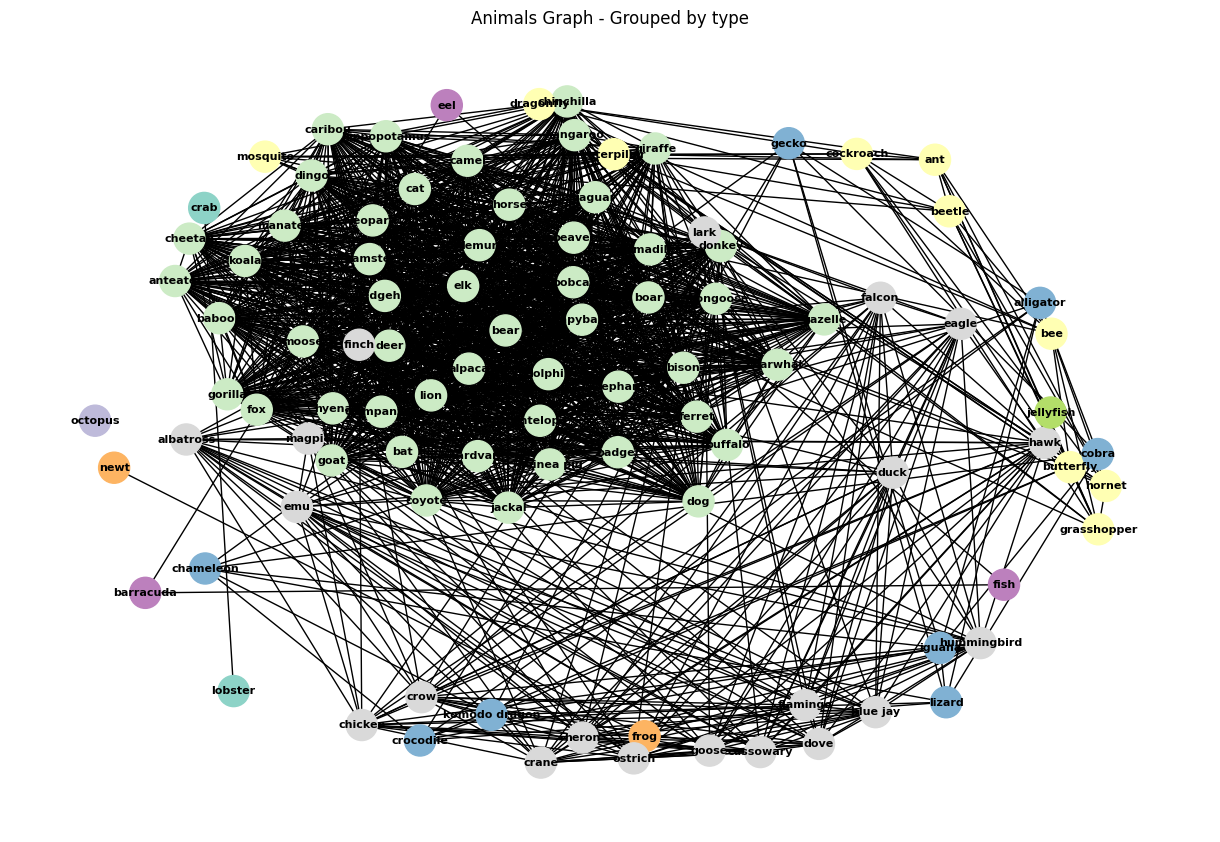

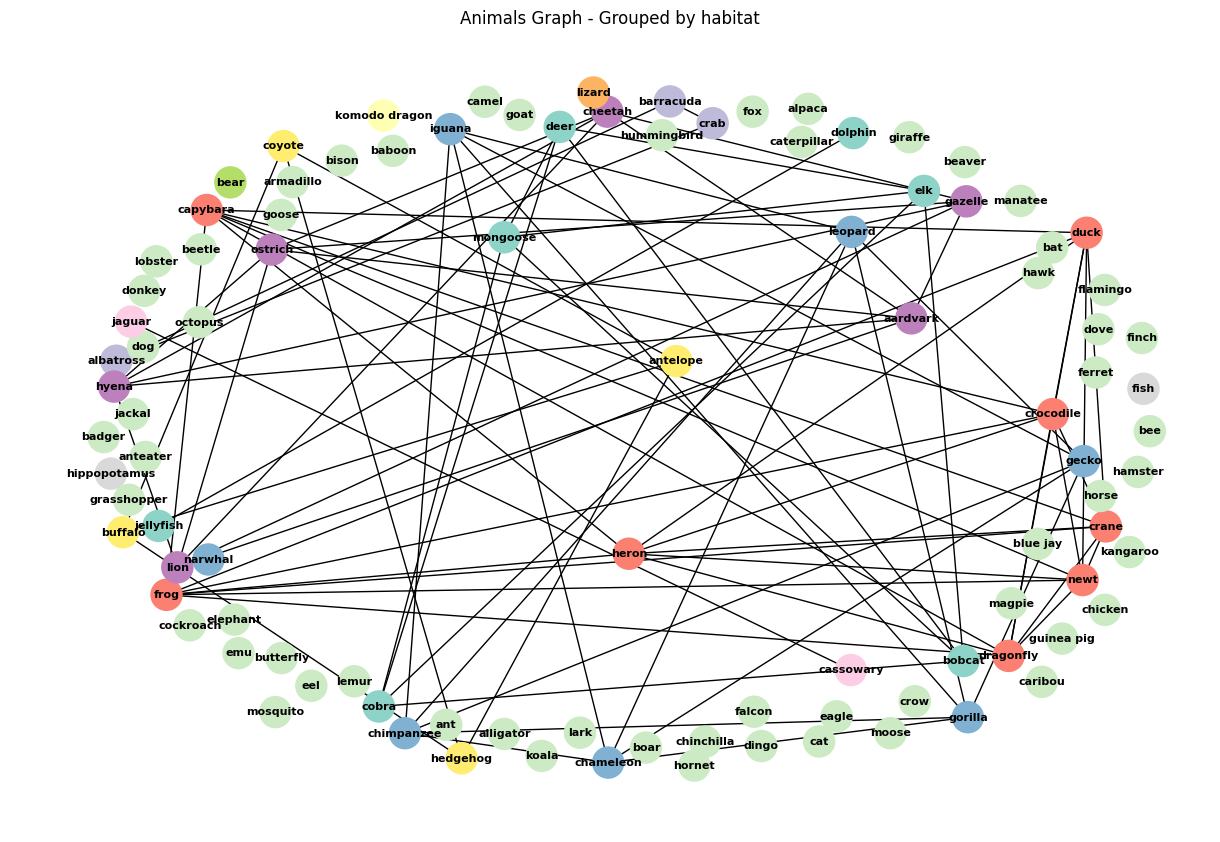

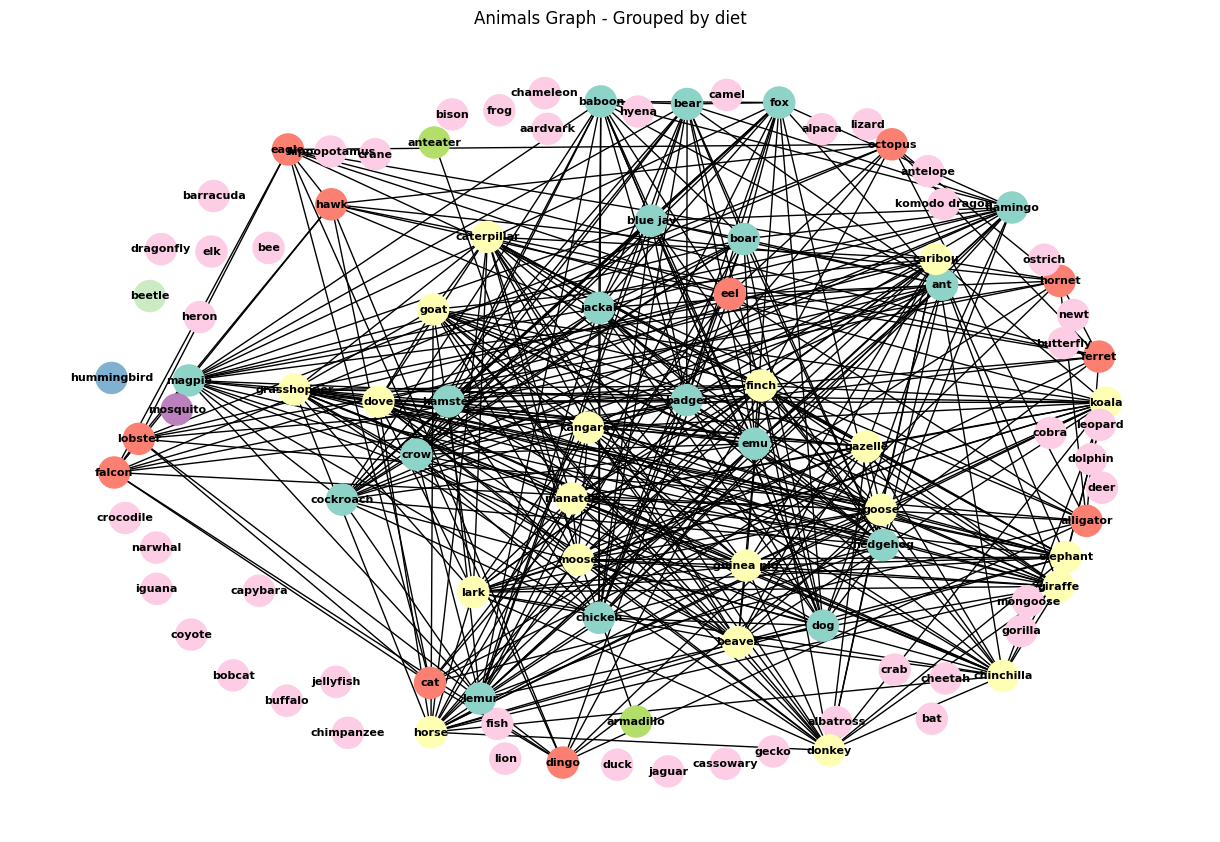

GraphRAG Visualizer ready to use!
Import your animals data and call visualize_animals_graph(animals)


In [46]:
import networkx as nx
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import pandas as pd
from collections import defaultdict, Counter
import numpy as np
from typing import List, Dict, Any
import seaborn as sns

class GraphRAGVisualizer:
    """
    A comprehensive visualization tool for Graph RAG data
    """

    def __init__(self, documents: List[Any]):
        """
        Initialize with list of Document objects

        Args:
            documents: List of Document objects with id, metadata, and page_content
        """
        self.documents = documents
        self.graph = None
        self._build_graph()

    def _build_graph(self):
        """Build NetworkX graph from documents"""
        self.graph = nx.Graph()

        # Add nodes
        for doc in self.documents:
            self.graph.add_node(
                doc.id,
                **doc.metadata,
                content=doc.page_content[:100] + "..." if len(doc.page_content) > 100 else doc.page_content
            )

        # Add edges based on shared attributes
        nodes = list(self.graph.nodes(data=True))
        for i, (node1, data1) in enumerate(nodes):
            for j, (node2, data2) in enumerate(nodes[i+1:], i+1):
                weight = self._calculate_similarity(data1, data2)
                if weight > 0:
                    self.graph.add_edge(node1, node2, weight=weight)

    def _calculate_similarity(self, data1: Dict, data2: Dict) -> float:
        """Calculate similarity between two nodes"""
        similarity = 0

        # Type similarity
        if data1.get('type') == data2.get('type'):
            similarity += 3

        # Habitat similarity
        if data1.get('habitat') == data2.get('habitat') and data1.get('habitat'):
            similarity += 2

        # Diet similarity
        if data1.get('diet') == data2.get('diet') and data1.get('diet'):
            similarity += 2

        # Number of legs similarity
        if data1.get('number_of_legs') == data2.get('number_of_legs'):
            similarity += 1

        # Keywords overlap
        keywords1 = set(data1.get('keywords', []))
        keywords2 = set(data2.get('keywords', []))
        common_keywords = len(keywords1.intersection(keywords2))
        similarity += common_keywords * 0.5

        return similarity

    def plot_networkx_graph(self, layout='spring', figsize=(15, 10),
                           node_color_attr='type', edge_threshold=1.0):
        """
        Create NetworkX visualization with matplotlib

        Args:
            layout: Layout algorithm ('spring', 'circular', 'kamada_kawai', etc.)
            figsize: Figure size tuple
            node_color_attr: Attribute to color nodes by
            edge_threshold: Minimum edge weight to display
        """
        plt.figure(figsize=figsize)

        # Filter edges by threshold
        edges_to_draw = [(u, v) for u, v, d in self.graph.edges(data=True)
                        if d['weight'] >= edge_threshold]
        subgraph = self.graph.edge_subgraph(edges_to_draw)

        # Choose layout
        layout_funcs = {
            'spring': nx.spring_layout,
            'circular': nx.circular_layout,
            'kamada_kawai': nx.kamada_kawai_layout,
            'shell': nx.shell_layout,
            'random': nx.random_layout
        }

        pos = layout_funcs.get(layout, nx.spring_layout)(subgraph, k=3, iterations=50)

        # Get unique values for coloring
        color_values = [data.get(node_color_attr, 'unknown')
                       for _, data in subgraph.nodes(data=True)]
        unique_values = list(set(color_values))
        color_map = plt.cm.Set3(np.linspace(0, 1, len(unique_values)))
        node_colors = [color_map[unique_values.index(val)] for val in color_values]

        # Draw edges with varying thickness
        edge_weights = [subgraph[u][v]['weight'] for u, v in subgraph.edges()]
        nx.draw_networkx_edges(subgraph, pos, width=[w/2 for w in edge_weights],
                              alpha=0.6, edge_color='gray')

        # Draw nodes
        node_sizes = [len(data.get('keywords', [])) * 100 + 300
                     for _, data in subgraph.nodes(data=True)]
        nx.draw_networkx_nodes(subgraph, pos, node_color=node_colors,
                              node_size=node_sizes, alpha=0.8)

        # Draw labels
        nx.draw_networkx_labels(subgraph, pos, font_size=8, font_weight='bold')

        # Create legend
        legend_elements = [plt.Line2D([0], [0], marker='o', color='w',
                                     markerfacecolor=color_map[i], markersize=10,
                                     label=val) for i, val in enumerate(unique_values)]
        plt.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.15, 1))

        plt.title(f'Graph RAG Visualization - Colored by {node_color_attr}',
                 fontsize=16, fontweight='bold')
        plt.axis('off')
        plt.tight_layout()
        plt.show()

    def plot_interactive_plotly(self, node_color_attr='type', edge_threshold=1.0):
        """
        Create interactive Plotly visualization

        Args:
            node_color_attr: Attribute to color nodes by
            edge_threshold: Minimum edge weight to display
        """
        # Filter edges
        edges_to_draw = [(u, v) for u, v, d in self.graph.edges(data=True)
                        if d['weight'] >= edge_threshold]
        subgraph = self.graph.edge_subgraph(edges_to_draw)

        # Create layout
        pos = nx.spring_layout(subgraph, k=3, iterations=50)

        # Prepare edge traces
        edge_x = []
        edge_y = []
        edge_info = []

        for edge in subgraph.edges(data=True):
            x0, y0 = pos[edge[0]]
            x1, y1 = pos[edge[1]]
            edge_x.extend([x0, x1, None])
            edge_y.extend([y0, y1, None])
            edge_info.append(f"Connection: {edge[0]} - {edge[1]}<br>Weight: {edge[2]['weight']:.2f}")

        edge_trace = go.Scatter(x=edge_x, y=edge_y,
                               line=dict(width=0.5, color='#888'),
                               hoverinfo='none',
                               mode='lines')

        # Prepare node traces - FIX: Convert categorical to numeric
        node_x = []
        node_y = []
        node_text = []
        node_info = []
        node_colors = []
        node_sizes = []

        # Get unique categories and create mapping
        color_values = [data.get(node_color_attr, 'unknown')
                       for _, data in subgraph.nodes(data=True)]
        unique_categories = list(set(color_values))
        color_mapping = {cat: i for i, cat in enumerate(unique_categories)}

        for node, data in subgraph.nodes(data=True):
            x, y = pos[node]
            node_x.append(x)
            node_y.append(y)
            node_text.append(node)

            # Create hover info
            info = f"<b>{node}</b><br>"
            info += f"Type: {data.get('type', 'N/A')}<br>"
            info += f"Habitat: {data.get('habitat', 'N/A')}<br>"
            info += f"Diet: {data.get('diet', 'N/A')}<br>"
            info += f"Legs: {data.get('number_of_legs', 'N/A')}<br>"
            info += f"Keywords: {', '.join(data.get('keywords', []))}<br>"
            info += f"Content: {data.get('content', 'N/A')}"
            node_info.append(info)

            # Convert categorical to numeric for coloring
            category = data.get(node_color_attr, 'unknown')
            node_colors.append(color_mapping[category])
            node_sizes.append(len(data.get('keywords', [])) * 5 + 20)

        # Create custom colorscale for categories
        n_categories = len(unique_categories)
        colorscale = []
        colors = px.colors.qualitative.Set3[:n_categories]  # Use distinct colors

        for i, color in enumerate(colors):
            colorscale.append([i / max(1, n_categories - 1), color])

        # If only one category, create a simple colorscale
        if n_categories == 1:
            colorscale = [[0, colors[0]], [1, colors[0]]]

        node_trace = go.Scatter(x=node_x, y=node_y,
                               mode='markers+text',
                               hoverinfo='text',
                               text=node_text,
                               hovertext=node_info,
                               textposition="middle center",
                               marker=dict(size=node_sizes,
                                         color=node_colors,
                                         colorscale=colorscale,
                                         showscale=True,
                                         colorbar=dict(
                                             title=node_color_attr.title(),
                                             tickmode='array',
                                             tickvals=list(range(n_categories)),
                                             ticktext=unique_categories
                                         ),
                                         line=dict(width=2)))

        # Create figure
        fig = go.Figure(data=[edge_trace, node_trace],
                       layout=go.Layout(
                           title=f'Interactive Graph RAG Visualization - Colored by {node_color_attr}',
                           titlefont_size=16,
                           showlegend=False,
                           hovermode='closest',
                           margin=dict(b=20,l=5,r=5,t=40),
                           annotations=[ dict(
                               text="Hover over nodes for details. Node size = number of keywords",
                               showarrow=False,
                               xref="paper", yref="paper",
                               x=0.005, y=-0.002,
                               xanchor="left", yanchor="bottom",
                               font=dict(color="gray", size=12)
                           )],
                           xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                           yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                           plot_bgcolor='white'))

        fig.show()

    def create_analysis_dashboard(self):
        """Create a comprehensive analysis dashboard"""
        # Extract data for analysis
        types = [doc.metadata.get('type', 'unknown') for doc in self.documents]
        habitats = [doc.metadata.get('habitat', 'unknown') for doc in self.documents
                   if doc.metadata.get('habitat')]
        diets = [doc.metadata.get('diet', 'unknown') for doc in self.documents
                if doc.metadata.get('diet')]
        legs = [doc.metadata.get('number_of_legs', 0) for doc in self.documents]

        # All keywords
        all_keywords = []
        for doc in self.documents:
            all_keywords.extend(doc.metadata.get('keywords', []))

        # Create subplots
        fig = make_subplots(
            rows=2, cols=3,
            subplot_titles=('Animal Types Distribution', 'Habitat Distribution',
                          'Diet Distribution', 'Number of Legs',
                          'Top Keywords', 'Network Centrality'),
            specs=[[{"type": "pie"}, {"type": "pie"}, {"type": "pie"}],
                   [{"type": "bar"}, {"type": "bar"}, {"type": "bar"}]]
        )

        # Type distribution
        type_counts = Counter(types)
        fig.add_trace(go.Pie(labels=list(type_counts.keys()),
                            values=list(type_counts.values()),
                            name="Types"), row=1, col=1)

        # Habitat distribution
        habitat_counts = Counter(habitats)
        fig.add_trace(go.Pie(labels=list(habitat_counts.keys()),
                            values=list(habitat_counts.values()),
                            name="Habitats"), row=1, col=2)

        # Diet distribution
        diet_counts = Counter(diets)
        fig.add_trace(go.Pie(labels=list(diet_counts.keys()),
                            values=list(diet_counts.values()),
                            name="Diets"), row=1, col=3)

        # Number of legs
        legs_counts = Counter(legs)
        fig.add_trace(go.Bar(x=list(legs_counts.keys()),
                            y=list(legs_counts.values()),
                            name="Legs Count"), row=2, col=1)

        # Top keywords
        keyword_counts = Counter(all_keywords)
        top_keywords = keyword_counts.most_common(10)
        fig.add_trace(go.Bar(x=[k[0] for k in top_keywords],
                            y=[k[1] for k in top_keywords],
                            name="Keywords"), row=2, col=2)

        # Network centrality
        centrality = nx.degree_centrality(self.graph)
        top_central = sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:10]
        fig.add_trace(go.Bar(x=[item[0] for item in top_central],
                            y=[item[1] for item in top_central],
                            name="Centrality"), row=2, col=3)

        fig.update_layout(height=800, showlegend=False,
                         title_text="Graph RAG Analysis Dashboard")
        fig.show()

    def get_network_statistics(self):
        """Get comprehensive network statistics"""
        stats = {
            'Total Nodes': self.graph.number_of_nodes(),
            'Total Edges': self.graph.number_of_edges(),
            'Average Degree': sum(dict(self.graph.degree()).values()) / self.graph.number_of_nodes(),
            'Density': nx.density(self.graph),
            'Connected Components': nx.number_connected_components(self.graph),
            'Average Clustering': nx.average_clustering(self.graph),
            'Diameter': nx.diameter(self.graph) if nx.is_connected(self.graph) else 'Graph not connected'
        }

        print("=== NETWORK STATISTICS ===")
        for key, value in stats.items():
            print(f"{key}: {value}")

        # Most connected nodes
        degree_centrality = nx.degree_centrality(self.graph)
        top_connected = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]

        print("\n=== MOST CONNECTED ANIMALS ===")
        for animal, centrality in top_connected:
            print(f"{animal}: {centrality:.3f}")

        return stats

    def analyze_clusters(self, method='louvain'):
        """Analyze clusters in the graph"""
        if method == 'louvain':
            try:
                import community as community_louvain
                partition = community_louvain.best_partition(self.graph)
            except ImportError:
                print("python-louvain not installed, using connected components instead")
                components = list(nx.connected_components(self.graph))
                partition = {}
                for i, comp in enumerate(components):
                    for node in comp:
                        partition[node] = i
        else:
            # Use connected components as fallback
            components = list(nx.connected_components(self.graph))
            partition = {}
            for i, comp in enumerate(components):
                for node in comp:
                    partition[node] = i

        # Analyze clusters
        clusters = defaultdict(list)
        for node, cluster_id in partition.items():
            node_data = self.graph.nodes[node]
            clusters[cluster_id].append({
                'name': node,
                'type': node_data.get('type', 'unknown'),
                'habitat': node_data.get('habitat', 'unknown'),
                'diet': node_data.get('diet', 'unknown')
            })

        print(f"\n=== CLUSTER ANALYSIS ({method.upper()}) ===")
        print(f"Found {len(clusters)} clusters")

        for cluster_id, nodes in clusters.items():
            if len(nodes) > 1:  # Only show clusters with multiple nodes
                print(f"\nCluster {cluster_id} ({len(nodes)} animals):")
                types = [node['type'] for node in nodes]
                habitats = [node['habitat'] for node in nodes]
                diets = [node['diet'] for node in nodes]

                print(f"  Types: {Counter(types)}")
                print(f"  Habitats: {Counter(habitats)}")
                print(f"  Diets: {Counter(diets)}")
                print(f"  Animals: {[node['name'] for node in nodes[:10]]}{'...' if len(nodes) > 10 else ''}")

        return partition

# Usage functions
def visualize_animals_graph(animals):
    """
    Main function to visualize the animals graph

    Args:
        animals: List of Document objects from fetch_documents()
    """

    # Create visualizer
    visualizer = GraphRAGVisualizer(animals)

    # Print network statistics
    visualizer.get_network_statistics()

    # Analyze clusters
    visualizer.analyze_clusters()

    # Create different visualizations
    print("\n1. Creating NetworkX visualization...")
    visualizer.plot_networkx_graph(layout='spring', node_color_attr='type')

    print("\n2. Creating interactive Plotly visualization...")
    visualizer.plot_interactive_plotly(node_color_attr='type')

    print("\n3. Creating analysis dashboard...")
    visualizer.create_analysis_dashboard()

    return visualizer

def quick_graph_plot(animals, attribute='type', layout='spring'):
    """Quick and simple graph plot"""
    G = nx.Graph()

    # Add nodes
    for doc in animals:
        G.add_node(doc.id, **doc.metadata)

    # Add edges based on shared attribute
    nodes = list(G.nodes(data=True))
    for i, (node1, data1) in enumerate(nodes):
        for j, (node2, data2) in enumerate(nodes[i+1:], i+1):
            if data1.get(attribute) == data2.get(attribute) and data1.get(attribute):
                G.add_edge(node1, node2)

    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G, k=2, iterations=50)

    # Color by attribute
    colors = [data.get(attribute, 'unknown') for _, data in G.nodes(data=True)]
    unique_colors = list(set(colors))
    color_map = {color: plt.cm.Set3(i/len(unique_colors))
                for i, color in enumerate(unique_colors)}
    node_colors = [color_map[color] for color in colors]

    nx.draw(G, pos, node_color=node_colors, with_labels=True,
            node_size=500, font_size=8, font_weight='bold')

    plt.title(f'Animals Graph - Grouped by {attribute}')
    plt.show()

# Example usage:
if __name__ == "__main__":
    # Assuming you have your animals data:
    from graph_rag_example_helpers.datasets.animals import fetch_documents
    animals = fetch_documents()

    # Full visualization suite
    # visualizer = visualize_animals_graph(animals)

    # Or quick plot
    quick_graph_plot(animals, attribute='type')
    quick_graph_plot(animals, attribute='habitat')
    quick_graph_plot(animals, attribute='diet')

    print("GraphRAG Visualizer ready to use!")
    print("Import your animals data and call visualize_animals_graph(animals)")

In [8]:
len(animals)

99

In [9]:
animals[0].page_content

'the aardvark is a nocturnal mammal known for its burrowing habits and long snout used to sniff out ants.'

In [10]:
animals[0].metadata

{'type': 'mammal',
 'number_of_legs': 4,
 'keywords': ['burrowing', 'nocturnal', 'ants', 'savanna'],
 'habitat': 'savanna',
 'tags': [{'a': 5, 'b': 7}, {'a': 8, 'b': 10}]}

In [28]:
from google.colab import userdata
import os

os.environ["GOOGLE_API_KEY"] = userdata.get("GOOGLE_API_KEY")
os.environ["HF_TOKEN"] = userdata.get("HF_TOKEN")

In [14]:
from langchain_huggingface import HuggingFaceEmbeddings

embedding=HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [15]:
embedding.embed_query(animals[0].page_content)

[0.023793525993824005,
 0.056134480983018875,
 -0.04561781510710716,
 0.12254826724529266,
 0.006605931092053652,
 -0.030046237632632256,
 0.04173852130770683,
 -0.004468299448490143,
 0.022790927439928055,
 0.0919870063662529,
 -0.05208764597773552,
 -0.040777575224637985,
 -0.06861700862646103,
 0.04860876873135567,
 -0.0893891304731369,
 0.06345506757497787,
 0.011628365144133568,
 0.010342644527554512,
 0.10459260642528534,
 -0.018075857311487198,
 0.027292679995298386,
 0.039325207471847534,
 0.10384543985128403,
 -0.03403109684586525,
 -0.05695992335677147,
 -0.052138544619083405,
 -0.0014581922441720963,
 -0.012236488983035088,
 -0.04013173654675484,
 -0.0909828469157219,
 -0.03595581278204918,
 -0.04767214134335518,
 0.03450756147503853,
 -0.046954844146966934,
 0.011210907250642776,
 0.06851484626531601,
 -0.008312803693115711,
 0.027267761528491974,
 0.07124543190002441,
 0.03501970320940018,
 0.08304338157176971,
 -0.020919984206557274,
 0.0413440465927124,
 -0.0028331754729

In [16]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store=InMemoryVectorStore.from_documents(
    documents=animals,
    embedding=embedding
)

In [18]:
from graph_retriever.strategies import Eager
from langchain_graph_retriever import GraphRetriever

In [19]:
traversal_retriever = GraphRetriever(
    store = vector_store,
    edges = [("habitat", "habitat"), ("origin", "origin")],
    strategy = Eager(k=5, start_k=1, max_depth=2),
)

In [20]:
traversal_retriever

GraphRetriever(store=<langchain_core.vectorstores.in_memory.InMemoryVectorStore object at 0x7e7dc799e910>, edges=[('habitat', 'habitat'), ('origin', 'origin')], strategy=Eager(select_k=5, start_k=1, adjacent_k=10, max_traverse=None, max_depth=2, _query_embedding=[]), adapter=<langchain_graph_retriever.adapters.in_memory.InMemoryAdapter object at 0x7e7dc6936650>)

In [21]:
results=traversal_retriever.invoke("what animal could be found near a anaconda?")

In [22]:
len(results)

5

In [24]:
results[0].metadata

{'_depth': 0,
 '_similarity_score': 0.45473089916547793,
 'type': 'reptile',
 'number_of_legs': 4,
 'keywords': ['large lizard', 'herbivore', 'basking'],
 'habitat': 'forest'}

In [25]:
from langchain.chat_models import init_chat_model

In [26]:
llm = init_chat_model("gemini-2.0-flash", model_provider="google_genai")

In [27]:
llm.invoke("hi")

AIMessage(content='Hi there! How can I help you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--5cec0ea5-e99e-4719-9586-b7333236a003-0', usage_metadata={'input_tokens': 1, 'output_tokens': 11, 'total_tokens': 12, 'input_token_details': {'cache_read': 0}})

In [29]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough

prompt = ChatPromptTemplate.from_template(
"""Answer the question based only on the context provided.

Context: {context}

Question: {question}"""
)

def format_docs(docs):
    return "\n\n".join(f"text: {doc.page_content} metadata: {doc.metadata}" for doc in docs)

In [30]:
chain = (
    {"context": traversal_retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

In [31]:
chain.invoke("what animal could be found near a anaconda?")

'The provided texts do not mention anacondas. Therefore, it is impossible to answer the question based on the context.'

In [32]:
chain.invoke("what animal could be found near a tiger?")

'The provided context does not contain information about tigers or where they can be found. Therefore, I cannot answer the question.'

In [33]:
chain.invoke("what animal can be found in south America?")

"The provided text describes bison, which are found in North America, not South America. The text doesn't mention any animals found in South America."

In [34]:
chain.invoke("what all animal can be found in south America give me all the names?")

'The context provided does not contain information about animals found in South America.'